In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1bf262412d5510048c92213df07f3112c25e646c5fb54ed3ebc779b6567d2d9c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=44c92324a3b11c1b04ae4d83e22d98e1d218b0af9dbbf0cde44793aa90edd30a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 15.35 MiB/s, done.


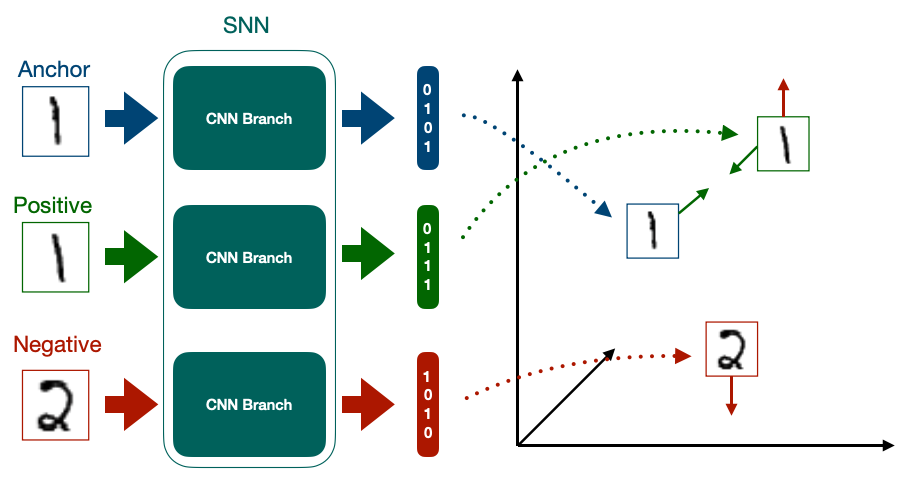

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE = 32
LR = 0.001
EPOCHS =15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)

In [7]:
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [8]:
row = df.iloc[4]

In [9]:
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


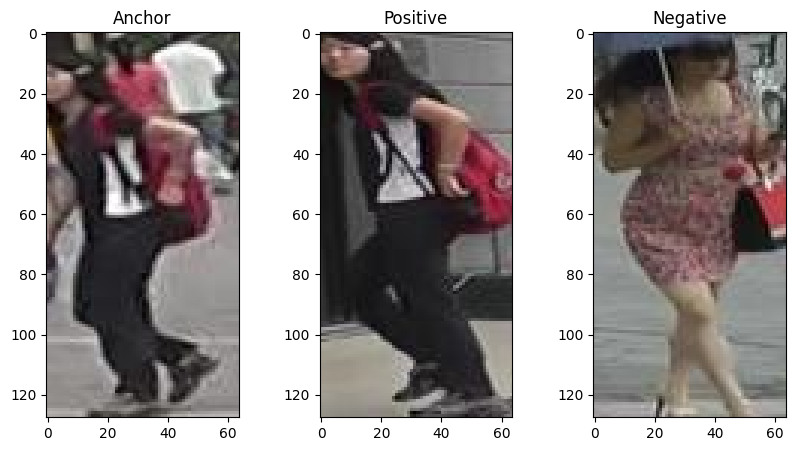

In [10]:
f, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A_img)
ax2.set_title('Positive')
ax2.imshow(P_img)
ax3.set_title('Negative')
ax3.imshow(N_img)

In [11]:
train_df, valid_df = train_test_split(df,test_size=0.20,random_state = 42)

# Create APN Dataset

In [12]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0 ,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2, 0 ,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2, 0 ,1)/255.0

    return A_img, P_img, N_img

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'size of trainset: {len(trainset)}')
print(f'size of validset: {len(validset)}')

size of trainset: 3200
size of validset: 800


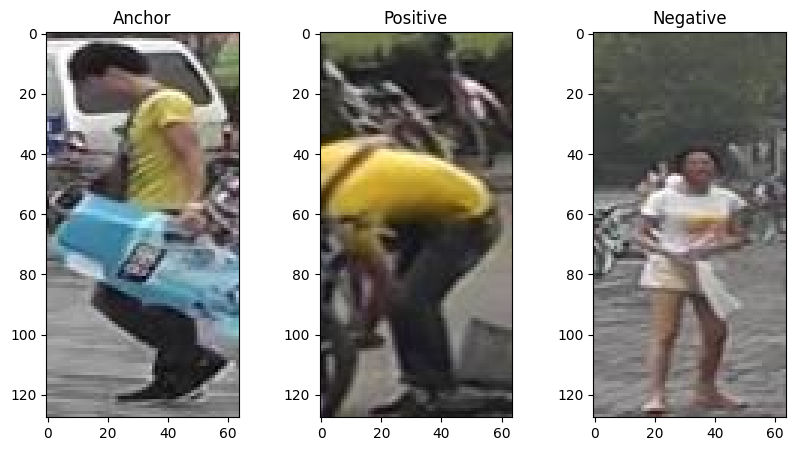

In [14]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [17]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [18]:
class APN_Model(nn.Module):
  def __init__(self, emb_size= 512):
    super(APN_Model,self).__init__()

    self.efficientnet = timm.create_model("efficientnet_b0", pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features,out_features=emb_size)

  def forward(self, image):

    embeddings = self.efficientnet(image)

    return embeddings

In [19]:
model = APN_Model()
model.to(DEVICE);

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [20]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [21]:
def valid_fn(model, dataloader, criterion):
  model.eval() #off Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
    return total_loss/len(dataloader)


In [22]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

# Create Training Loop

In [23]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader,optimizer, criterion)
  valid_loss = valid_fn(model, validloader, criterion)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),"best_model.pt")
    best_valid_loss = valid_loss
    print("WEIGHT SAVE SUCCESS")

  print(f'EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}')

100%|██████████| 25/25 [00:02<00:00, 11.01it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 1 train_loss : 0.6392988774180413 valid_loss : 0.8662810695171356


100%|██████████| 25/25 [00:02<00:00,  8.91it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 2 train_loss : 0.3768531672656536 valid_loss : 0.44145948827266696


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 3 train_loss : 0.18335416212677955 valid_loss : 0.26005730748176575


100%|██████████| 25/25 [00:02<00:00, 10.93it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 4 train_loss : 0.12161533489823341 valid_loss : 0.1952899032831192


100%|██████████| 25/25 [00:02<00:00, 11.13it/s]


EPOCHS : 5 train_loss : 0.08287827596068383 valid_loss : 0.3147083580493927


100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


EPOCHS : 6 train_loss : 0.0844963949918747 valid_loss : 0.22511900901794435


100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


EPOCHS : 7 train_loss : 0.06953521236777306 valid_loss : 0.22098733127117157


100%|██████████| 25/25 [00:02<00:00, 11.09it/s]


EPOCHS : 8 train_loss : 0.08221978053450585 valid_loss : 0.21947323858737947


100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


EPOCHS : 9 train_loss : 0.0525954632461071 valid_loss : 0.21543394923210143


100%|██████████| 25/25 [00:02<00:00, 10.59it/s]


EPOCHS : 10 train_loss : 0.04798735916614533 valid_loss : 0.19957570731639862


100%|██████████| 25/25 [00:02<00:00,  8.83it/s]


EPOCHS : 11 train_loss : 0.05492629662156105 valid_loss : 0.21541806161403657


100%|██████████| 25/25 [00:02<00:00, 10.87it/s]


EPOCHS : 12 train_loss : 0.05225370019674301 valid_loss : 0.20734719395637513


100%|██████████| 25/25 [00:02<00:00,  8.75it/s]


EPOCHS : 13 train_loss : 0.06236830994486809 valid_loss : 0.26899541199207305


100%|██████████| 25/25 [00:02<00:00, 10.77it/s]


WEIGHT SAVE SUCCESS
EPOCHS : 14 train_loss : 0.05164149411022663 valid_loss : 0.1869204419851303


100%|██████████| 25/25 [00:03<00:00,  7.85it/s]

EPOCHS : 15 train_loss : 0.0335022384673357 valid_loss : 0.247011838555336


# Get Anchor Embeddings

In [27]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []
  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) #(c,h,w)-> (bs,c,h,w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names,encodings],axis = 1)
  return df_enc

In [28]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model,df['Anchor'])

100%|██████████| 4000/4000 [00:43<00:00, 91.49it/s] 


In [29]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.977258,0.743784,0.812951,-1.447803,-0.645332,-0.149187,0.572689,0.040403,-0.226356,...,0.048307,0.612254,-0.130748,-0.485449,0.201675,0.723843,-0.603395,0.749137,0.305714,0.405640
1,1420_c3s3_061978_03.jpg,-0.655104,0.576888,0.589857,-0.675329,-0.524220,-0.148530,0.627064,0.244498,0.051527,...,-0.318136,0.197972,-0.024648,-0.197519,0.055708,0.590455,-0.509548,0.302553,0.291911,0.022399
2,1420_c5s3_062565_05.jpg,-0.646013,0.837819,0.925393,-0.946476,-0.447282,-0.191442,0.761559,0.360163,-0.029106,...,-0.117115,0.158011,0.002003,-0.387751,0.230888,0.479657,-0.696653,0.456350,0.464948,0.195432
3,1420_c6s3_085592_04.jpg,-1.045114,-0.236132,-0.066749,-0.823350,-0.481983,-0.011901,0.133628,-0.237581,-0.277841,...,-0.059897,0.886652,-0.078534,0.233945,-0.324644,1.185171,0.024366,0.592431,0.114020,0.149992
4,0663_c5s3_085987_03.jpg,-0.546672,-0.593661,-0.429102,-0.324890,-0.209862,-0.072472,-0.418994,-0.305352,-0.199064,...,0.355876,0.199686,0.004080,0.069476,-0.666644,0.426506,0.829180,0.677463,-0.198784,0.607855


# Inference

In [31]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc-anc_enc_arr).T))
  return dist

In [34]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR  + img_name


img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()



In [36]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [38]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc,anc_enc_arr[i:i+1,:])
  distance = np.append(distance,dist)

closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


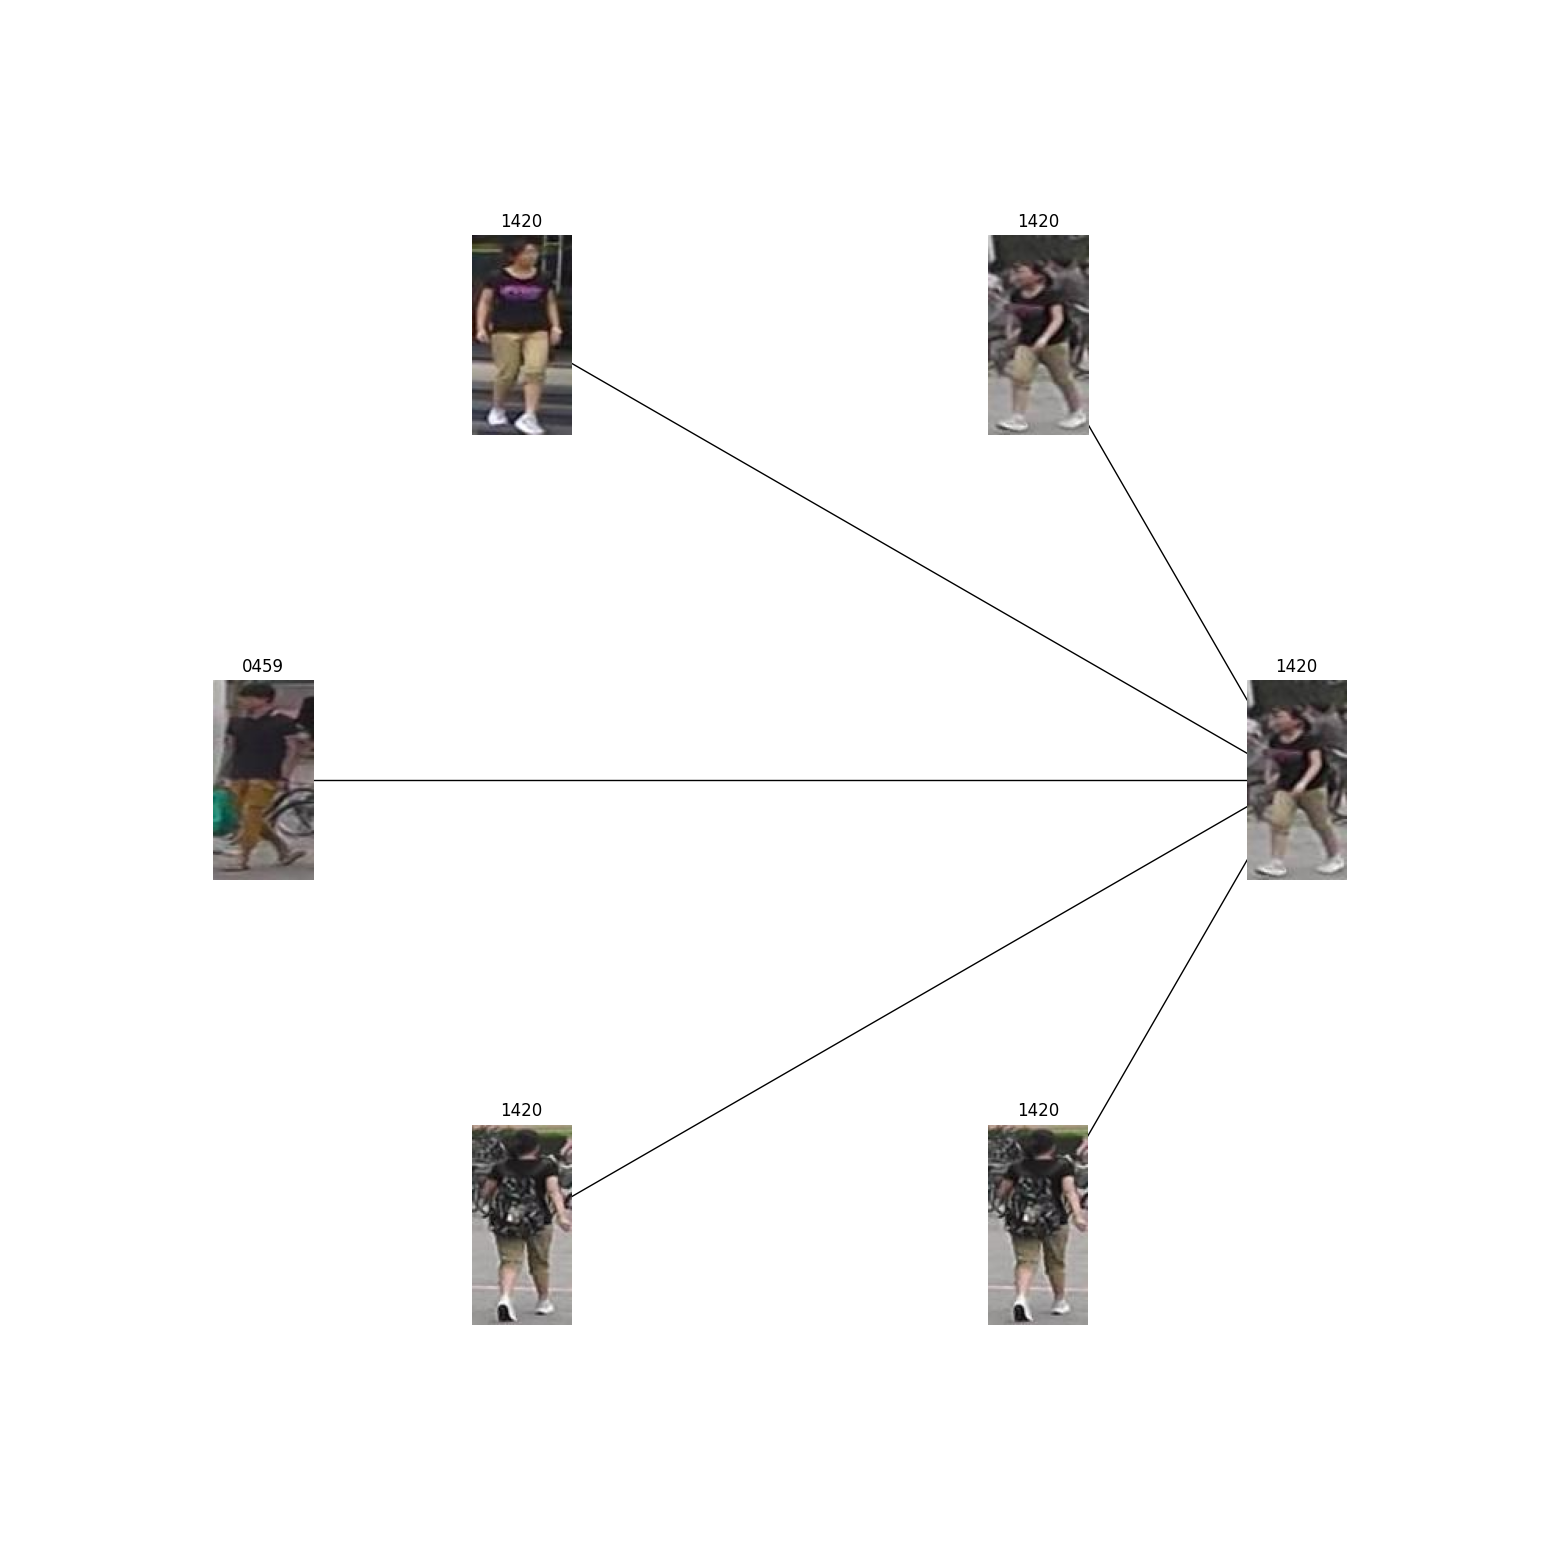

In [39]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);